In [1]:
from pathlib import Path
import numpy as np
from funcionesTP import *

path_dataset_train = '../TP/template-alumnos/dataset/cats_and_dogs/train'
path_dataset_val = '../TP/template-alumnos/dataset/cats_and_dogs/val'

def cargarDataset(carpeta: Path):
    """
    carpeta Path a la carpeta de train / val
    retorna la matriz de embeddings (1536x2000 / 1536x1000) y la matriz Y (2x2000 / 2x1000)
    """
    
    pathCats = carpeta.joinpath('cats/efficientnet_b3_embeddings.npy')
    pathDogs = carpeta.joinpath('dogs/efficientnet_b3_embeddings.npy')

    embeddingsCats = np.load(pathCats)
    embeddingsDogs = np.load(pathDogs)

    embeddings = np.concatenate((embeddingsCats, embeddingsDogs), axis=1)
    _, m = embeddings.shape

    Y = np.zeros((2,m))
    for i in range(0, int(m/2)):
        Y[0,i] = 1

    for i in range(int(m/2), m):
        Y[1,i] = 1

    return embeddings, Y

def cargarDatasetCompleto():
    """
    retorna el dataset de entrenamiento (X_t, Y_t) y el de valuación (X_v, Y_v)
    """

    
    Xt, Yt = cargarDataset(Path(path_dataset_train))
    Xv, Yv = cargarDataset(Path(path_dataset_val))

    return Xt, Yt, Xv, Yv

Las siguientes funciones generan la matriz W a partir del calculo de la pseudoinversa de X utilizando diferentes metodos de decomposicion

In [ ]:
def generar_W_EcuacionesNormales():
    Xt, Yt = cargarDataset(Path(path_dataset_train))

    n, p = Xt.shape
    rangoX = min(n, p)

    if rangoX == p and rangoX < n:
        XtX = productoMatricial(traspuesta(Xt), Xt)
        L = cholesky(XtX)
        W = pinvEcuacionesNormales(Xt, L, Yt)

    elif rangoX == n and rangoX < p:
        XXt = productoMatricial(Xt, traspuesta(Xt))
        L = cholesky(XXt)
        W = pinvEcuacionesNormales(Xt, L, Yt)

    elif rangoX == p and p == n:
        W = pinvEcuacionesNormales(Xt, None, Yt)


    np.save('./W_eqnormales', W)

def generar_W_QRHH():
    Xt, Yt = cargarDataset(Path(path_dataset_train))

    Q, R = QR_con_HH(traspuesta(Xt))
    W = pinvHouseHolder(Q, R, Yt)
    np.save('./W_qrhh', W)

def generar_W_QRGS():
    Xt, Yt = cargarDataset(Path(path_dataset_train))

    Q, R = QR_con_GS(traspuesta(Xt)) # type: ignore
    W = pinvGramSchmidt(Q, R, Yt)
    np.save('./W_qrgs', W)

def generar_W_SVD():
    Xt, Yt = cargarDataset(Path(path_dataset_train))

    # SVD REDUCIDA ME DA V1 DIRECTAMENTE
    U, S, V1 = svd_reducida(Xt)

    W = pinvSVD(U, S, V1, Yt)
    np.save('./W_SVD', W)
    

Utilizando estas cuatro funciones, generamos la matriz de pesos *W* con los distintos métodos

In [3]:
generar_W_EcuacionesNormales()

100%|██████████| 1536/1536 [13:08<00:00,  1.95it/s]


In [ ]:
generar_W_QRGS()

In [ ]:
generar_W_QRHH()

In [ ]:
generar_W_SVD()

Creamos la función `test_W()` que nos va a ayudar a testear los métodos midiendo $||Y - WX||_2$ 

In [4]:
def test_W(path_W, dataset = ['val', 'train']):
    """
    path_W Path al archivo de la matriz de pesos W generada con alguno de los métodos
    dataset las matrices que se van a usar para el test. Puede elegir entre entrenamiento o validación     

    utilizando la norma 2, calculamos la norma del residuo ||Y - WX||_2 para tener una medida error
    sobre el conjunto de validación.

    Retorna Norma 2 de la diferencia entre Y y W @ X
    """
    W = np.load(path_W)
    Xv, Yv = cargarDataset(Path(f'../TP/template-alumnos/dataset/cats_and_dogs/{dataset}'))

    matrizDiferencia = Yv - (W @ Xv)
    return np.linalg.norm(matrizDiferencia, ord=2)

Con la ayuda de esta función, midamos la precisión de cada uno de los métodos

In [7]:
metodos = ['./W_qrgs.npy', './W_qrhh.npy', './W_eqnormales.npy', './W_SVD.npy']
for metodo in metodos:
    print('-', metodo)
    print('norma 2 con matrices de entrenamiento: ', test_W(metodo, 'train'))
    print('norma 2 con matrices de validación:    ', test_W(metodo, 'val'))
    print()

- ./W_qrgs.npy
norma 2 con matrices de entrenamiento:  12.70724989849409
norma 2 con matrices de validación:     36.730114624119295

- ./W_qrhh.npy
norma 2 con matrices de entrenamiento:  12.707249898494087
norma 2 con matrices de validación:     36.730114624119246

- ./W_eqnormales.npy
norma 2 con matrices de entrenamiento:  20.608797859195807
norma 2 con matrices de validación:     36.712940570788994

- ./W_SVD.npy
norma 2 con matrices de entrenamiento:  12.707249898494558
norma 2 con matrices de validación:     36.73011483048146



La función `valoresDeConfusion` genera los valores positivos y negativos para cada tipo de clasificación (perros y gatos)

In [15]:
def valoresDeConfusion(path_W):
    """
    path_W Path al archivo de la matriz de pesos W generada con alguno de los métodos
    
    Evalúa el modelo contando cuántos gatos y perros fueron clasificados correctamente y cuántos incorrectamente.

    retorna los verdaderos y falsos positivos de gatos y de perros
    """


    W = np.load(path_W)
    Xv, _ = cargarDataset(Path('../TP/template-alumnos/dataset/cats_and_dogs/val'))
    matriz_resultado = W@Xv 
    gatos_positivos = 0

    for i in range(500):
        resultado = matriz_resultado[:,i]
        if resultado[0] > resultado[1]:
            gatos_positivos += 1 
    
    perros_positivos = 0

    for i in range(500, 1000):
        resultado = matriz_resultado[:,i]
        if resultado[1] > resultado[0]:
            perros_positivos += 1

    return np.array([
        [gatos_positivos, 500 - perros_positivos], 
        [500 - gatos_positivos, perros_positivos]  
    ])


Ahora graficamos la matriz de confusión de cada método

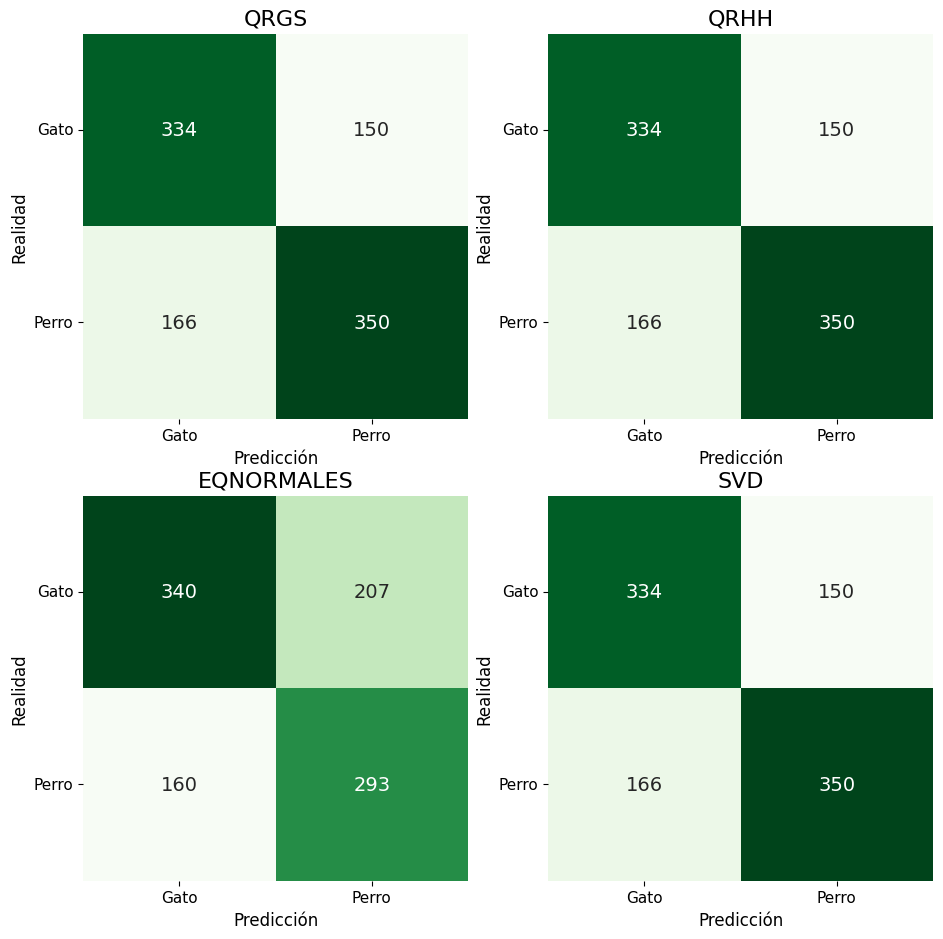

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(11, 11))
axes = axes.flatten() # Aplanamos para iterar fácilmente
for i, metodo in enumerate(metodos):
    cm = valoresDeConfusion(metodo)
    # 3. Limpiamos el nombre del método para el título
    nombre_metodo = str(metodo).replace('./W_', '').replace('.npy', '').upper()
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', ax=axes[i], 
                annot_kws={"size": 14}, cbar=False, square=True)
    
    axes[i].set_title(nombre_metodo, fontsize=16)
    axes[i].set_xlabel('Predicción', fontsize=12)
    axes[i].set_ylabel('Realidad', fontsize=12)
    axes[i].set_xticklabels(['Gato', 'Perro'], fontsize=11)
    axes[i].set_yticklabels(['Gato', 'Perro'], fontsize=11, rotation=0)

plt.show()

para darle soporte empírico al informe, veamos el número de condición de las matrices $X$ y $X^TX$, recordando que éste último es $cond(X)^2$

In [36]:
Xt, _ = cargarDataset(Path(path_dataset_train))
Xv, _ = cargarDataset(Path(path_dataset_val))

cond_number = np.linalg.cond(Xt)
print(f"Condición de Xt: {cond_number}")
print(f"Condición de Xt^T Xt: {cond_number**2}")

cond_number = np.linalg.cond(Xv)
print(f"Condición de Xv: {cond_number}")
print(f"Condición de Xv^T Xv: {cond_number**2}")

Condición de Xt: 363.2504577636719
Condición de Xt^T Xt: 131950.890625
Condición de Xv: 195.83343505859375
Condición de Xv^T Xv: 38350.734375


# Sintesis Final
Tras la implementación y evaluación de los distintos métodos numéricos para el cálculo de la pseudoinversa de la matriz $X$ y posterior cálculo de la matriz de pesos $W$, hemos observado diferencias notables en el rendimiento y estabilidad de cada algoritmo.

En primer lugar, el menor de los tiempos de ejecución fue conseguido por la factorización QR mediante Householder (QRHH), con un tiempo total de 11m 52s. Este resultado contrasta significativamente con la versión previa del código (que demoraba \approx 1 hora por cada iteracion, lo que resulta en +1500 horas de ejecucion); la mejora radica en la optimización al cálculo de QR con HouseHolder que se basa en la siguiente observación:
$$ 
H = I - 2 vv^t\\
H A = (I - 2 vv^t) A\\
H A = A - 2 v (v^tA)\\
$$
Esta optimización nos evita tener que construir y extender la matriz $H_k$ en cada iteración, calculando $HA$ directamente con 2 multiplicaciones matriz-vector.


Por otro lado, QR mediante Gram-Schmidt (QRGS), aunque teóricamente comparable, resultó casi un 60% más lento (18m 59s). Esto se debe a {RAZONES RAZONES RAZONES RAZONES RAZONES}.

El caso de Ecuaciones Normales (56m 33s) presenta una anomalía interesante. Si bien teóricamente suele ser el método más directo ($A^TAx = A^Tb$), nuestra implementación sufrió penalizaciones de precisión, arrojando una norma de error de 20.6, superior al 12.7 obtenido por QR y SVD. Esto se fundamenta teóricamente en el condicionamiento de las matrices: mientras que la condición de nuestra matriz de entrenamiento es $cond(X) \approx 363$, el método de Ecuaciones Normales opera con la matriz $X^TX$, cuyo número de condición se eleva al cuadrado ($cond(X^TX) \approx 1.3 \times 10^5$). Esto se ve claramente cuando miramos las matrices de confusión de los métodos, donde Ecuaciones Normales tiene un 41.4% de falsos positivos en perros, contra el 30% de los demás métodos.

Finalmente, la descomposición en valores singulares (SVD) resultó computacionalmente inviable, con un tiempo de 463m 12s (más de 7 horas). La ineficiencia aquí recae en el cálculo de la SVD reducida utilizando el algoritmo recursivo de diagonalización (diagRH). Esto contrasta fuertemente con la función que ofrece numpy para la svd (np.linalg.svd), que desploma el tiempo de ejecución a 57 segundos.

Además, … nuestra implementación de producto matricial usa el algoritmo estándar de orden O(n^3), a diferencia del producto matricial de numpy que utiliza el algoritmo de Strassen de orden O(n^log₂(7)). Esta diferencia resulta en $\approx 10$ veces más de operaciones por cada producto de $2000x2000$.

En conclusión, para esta aplicación específica, QR Householder optimizado representa el mejor compromiso entre estabilidad numérica y eficiencia computacional, superando drásticamente a la implementación manual de SVD y evitando la inestabilidad inherente de las Ecuaciones Normales.
